# 1. Initialization

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from skimage import color
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import maxflow
from glob import glob

# 2. Load the dataset

Train: 276 images, 276 GTs
Validation: 59 images, 59 GTs
Test: 256 images, 256 GTs
Sample path: ./dataset\images\3_11_s.bmp


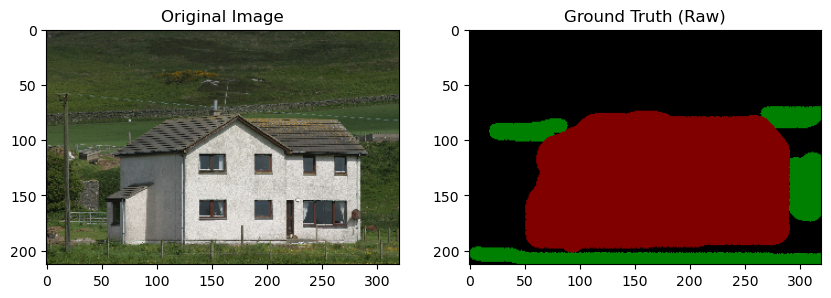

In [2]:
# dataset path
DATASET_ROOT = "./dataset" 
IMAGES_DIR = os.path.join(DATASET_ROOT, "images")
GT_DIR = os.path.join(DATASET_ROOT, "gt")
TRAIN_PATH = os.path.join(DATASET_ROOT, "Train.txt")
VALIDATION_PATH = os.path.join(DATASET_ROOT, "Validation.txt")
TEST_PATH = os.path.join(DATASET_ROOT, "Test.txt")

# load data function
def load_data_paths(txt_file, img_root, gt_root):
    """
    Read the txt file and return full paths for images and GTs
    Automatically handle file name suffixes, adapted for MSRC v2 format (e.g., 'foo' -> 'foo_GT.bmp')
    """
    image_paths = []
    gt_paths = []
    
    # Check if the index file exists
    if not os.path.exists(txt_file):
        print(f"Error: Index file {txt_file} not found")
        return [], []

    with open(txt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            filename = line.strip()
            if not filename: continue
            
            # --- Intelligent suffix handling ---
            # Whether the txt contains "1_3_s" or "1_3_s.bmp", we extract the base filename "1_3_s"
            if filename.lower().endswith('.bmp'):
                base_name = filename[:-4]
            elif filename.lower().endswith('.jpg'):
                base_name = filename[:-4]
            else:
                base_name = filename # Assume no suffix

            # --- Construct paths ---
            # Image path (assume all images are .bmp, change to .jpg if not)
            img_p = os.path.join(img_root, base_name + ".bmp")
            
            # GT path (core fix: append _GT.bmp)
            gt_p = os.path.join(gt_root, base_name + "_GT.bmp")
            
            if os.path.exists(img_p) and os.path.exists(gt_p):
                image_paths.append(img_p)
                gt_paths.append(gt_p)
            else:
                # Only print the first missing file for debugging to avoid flooding the output
                if len(image_paths) == 0:
                    print(f"Failed to load: \nImage: {img_p} \nGT: {gt_p}")
                    print("Please check: Does the image really exist? Is the GT filename really _GT.bmp?")
            
    return image_paths, gt_paths




train_img_paths, train_gt_paths = load_data_paths(TRAIN_PATH, IMAGES_DIR, GT_DIR)


val_img_paths, val_gt_paths = load_data_paths(VALIDATION_PATH, IMAGES_DIR, GT_DIR)


test_img_paths, test_gt_paths = load_data_paths(TEST_PATH, IMAGES_DIR, GT_DIR)


print(f"Train: {len(train_img_paths)} images, {len(train_gt_paths)} GTs")
print(f"Validation: {len(val_img_paths)} images, {len(val_gt_paths)} GTs")
print(f"Test: {len(test_img_paths)} images, {len(test_gt_paths)} GTs")

img_num = 15

if len(train_img_paths) > 0:
    print(f"Sample path: {train_img_paths[img_num]}")
    
    # Visualize the first image [cite: 59]
    sample_img = cv2.imread(train_img_paths[img_num])
    sample_gt = cv2.imread(train_gt_paths[img_num])
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 2, 2)
    plt.title("Ground Truth (Raw)")
    plt.imshow(cv2.cvtColor(sample_gt, cv2.COLOR_BGR2RGB))
    plt.show()
else:
    print("Warning: No images found, please check if the paths or file extensions are correct.")

# 3. Map the color

sample contains 3 unique colors (RGB):
 - [0 0 0]
 - [  0 128   0]
 - [128   0   0]

Starting to build mapping logic


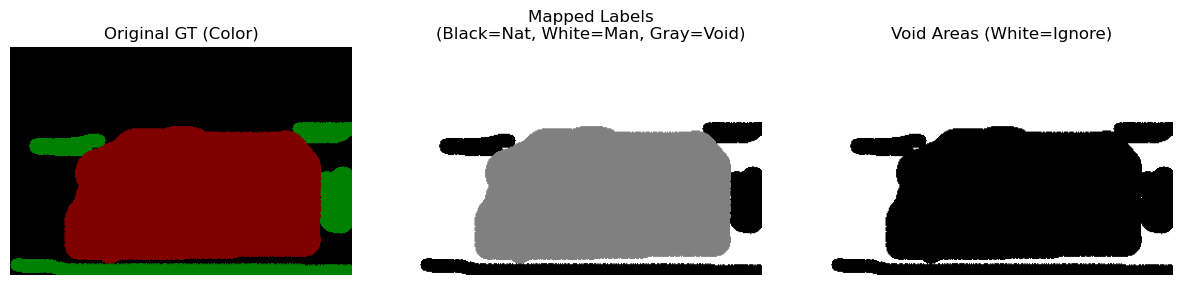

result of mapping:
 - natural pixels (0): 7173
 - man-made pixels (1): 26945
 - ignored pixels (255): 34042


In [3]:
# --- 检查 GT 颜色并建立映射 ---

if len(train_gt_paths) > 0:
    # 读取第一张 GT
    gt_sample = cv2.imread(train_gt_paths[img_num])
    # OpenCV 默认是 BGR，转为 RGB 方便人类阅读
    gt_sample = cv2.cvtColor(gt_sample, cv2.COLOR_BGR2RGB)
    
    # 获取图片中出现的所有唯一颜色值
    unique_colors = np.unique(gt_sample.reshape(-1, gt_sample.shape[2]), axis=0)
    
    print(f"sample contains {len(unique_colors)} unique colors (RGB):")
    for color in unique_colors:
        print(f" - {color}")
        
    print("\nStarting to build mapping logic")
else:
    print("Please resolve data loading issues first.")

# --- Define color mapping dictionary (based on MSRC standard) ---
# Below is the standard definition, you need to fine-tune based on the colors printed above
# Format: (R, G, B) : Class ID (0=Natural, 1=Man-made, 255=Ignore)

def get_msrc_mapping():
    mapping = {}
    
    # ===== 自然 (Natural) -> 0 =====
    mapping[(0, 128, 0)]     = 0  # Grass
    mapping[(0, 192, 0)]     = 0  # Grass Variant
    mapping[(128, 192, 128)] = 0  # Tree/Grass Light
    mapping[(0, 128, 128)]   = 0  # Tree
    mapping[(0, 64, 0)]      = 0  # Mountain
    mapping[(128, 128, 128)] = 0  # Sky
    mapping[(0, 0, 128)]     = 0  # Cow/Water
    mapping[(0, 128, 192)]   = 0  # Water
    
    # 动物修正
    mapping[(128, 128, 0)]   = 0  # Bird
    mapping[(0, 64, 128)]    = 0  # Sheep
    mapping[(64, 0, 128)]    = 0  # Cat
    mapping[(192, 128, 0)]   = 0  # Dog
    mapping[(64, 128, 0)]    = 0  # Horse
    
    # *** 你的侦探发现的新颜色 (关键!!!) ***
    mapping[(192, 64, 0)]    = 0  # 刚才的白色动物!
    mapping[(128, 64, 0)]    = 0  # 另一种动物
    mapping[(0, 192, 128)]   = 0  # 另一种草/动物
    
    mapping[(128, 0, 128)]   = 0  # Face/Person
    mapping[(192, 0, 128)]   = 0  # Flower

    # ===== 人造 (Man-made) -> 1 =====
    mapping[(128, 0, 0)]     = 1  # Building
    mapping[(0, 0, 192)]     = 1  # Airplane
    mapping[(64, 0, 0)]      = 1  # Car
    mapping[(0, 0, 64)]      = 1  # Bicycle
    mapping[(192, 0, 0)]     = 1  # Chair
    mapping[(64, 128, 128)]  = 1  # Sign
    mapping[(128, 64, 128)]  = 1  # Road
    mapping[(192, 128, 128)] = 1  # Sign variant
    mapping[(0, 64, 64)]     = 1  # Boat
    mapping[(0, 128, 64)]    = 1  # Body
    mapping[(192, 192, 128)] = 1  # Book
    
    # *** 你的侦探发现的人造颜色 ***
    mapping[(64, 64, 0)]     = 1  # Car/Chair Variant

    # ===== Void =====
    mapping[(0, 0, 0)]       = 255 

    return mapping

def mask_to_binary(mask_img, mapping):
    """Convert color mask to 0/1/255 matrix"""
    h, w = mask_img.shape[:2]
    # Default fill with Void (255)
    binary_mask = np.full((h, w), 255, dtype=np.uint8)
    
    for rgb_key, label in mapping.items():
        # Find all pixels in the image that match the rgb_key color
        # Note: mask_img must be in RGB format
        matches = np.all(mask_img == np.array(rgb_key), axis=-1)
        binary_mask[matches] = label
        
    return binary_mask

# Test conversion
# 假设 binary_gt 已经生成
if len(train_gt_paths) > 0:
    mapping = get_msrc_mapping()
    binary_gt = mask_to_binary(gt_sample, mapping)
    
    # --- 修正后的可视化代码 ---
    plt.figure(figsize=(15, 5))
    
    # 1. 原图
    plt.subplot(1, 3, 1)
    plt.title("Original GT (Color)")
    plt.imshow(gt_sample)
    plt.axis('off')
    
    # 2. 更好的掩膜显示 (区分三类)
    # 我们创建一个临时的可视化图，把 255 (Void) 变成 2 (灰色)，方便显示
    # 0=Black(Natural), 1=White(Man-made), 2=Gray(Void)
    vis_mask = binary_gt.copy()
    vis_mask[vis_mask == 255] = 2 
    
    plt.subplot(1, 3, 2)
    plt.title("Mapped Labels\n(Black=Nat, White=Man, Gray=Void)")
    # 使用灰度图显示: 0, 1, 2
    plt.imshow(vis_mask, cmap='gray', vmin=0, vmax=2)
    plt.axis('off')
    
    # 3. 验证 Void 区域
    plt.subplot(1, 3, 3)
    plt.title("Void Areas (White=Ignore)")
    plt.imshow(binary_gt == 255, cmap='gray')
    plt.axis('off')
    
    plt.show()
    
    # 打印一下验证数据
    print("result of mapping:")
    print(f" - natural pixels (0): {np.sum(binary_gt == 0)}")
    print(f" - man-made pixels (1): {np.sum(binary_gt == 1)}")
    print(f" - ignored pixels (255): {np.sum(binary_gt == 255)}")

In [4]:
import torch

# 自动检测是否有可用的 GPU，如果没有则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# 如果是 cuda，可以顺便打印一下显卡型号，确认没调错卡
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Usage: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
Memory Usage: 0.00 GB


dataset

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import random

# 设定统一的图像大小，U-Net通常喜欢 256x256 或 512x512
IMG_SIZE = (256, 256) 

import torchvision.transforms.functional as TF
import random

class MSRCDataset(Dataset):
    def __init__(self, img_paths, gt_paths, mapping, augment=False):
        self.img_paths = img_paths
        self.gt_paths = gt_paths
        self.mapping = mapping
        self.augment = augment # 新增开关，只在训练集开启增强

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert('RGB')
        gt_img = Image.open(self.gt_paths[idx]).convert('RGB')

        # 1. 基础 Resize (必须做)
        image = TF.resize(image, IMG_SIZE, interpolation=TF.InterpolationMode.BILINEAR)
        gt_img = TF.resize(gt_img, IMG_SIZE, interpolation=TF.InterpolationMode.NEAREST)

        # 2. 数据增强 (仅在训练模式下)
        if self.augment:
            # 2.1 随机水平翻转 (50% 概率)
            if random.random() > 0.5:
                image = TF.hflip(image)
                gt_img = TF.hflip(gt_img) # Mask 也要翻转！

            # 2.2 随机垂直翻转 (亦可尝试，针对 MSRC 这种自然场景可能不一定适合，这里暂时不加，你可以选加)
            
            # 2.3 随机旋转 (-10度 到 10度)
            if random.random() > 0.5:
                angle = random.randint(-10, 10)
                image = TF.rotate(image, angle)
                gt_img = TF.rotate(gt_img, angle)

            # 2.4 颜色抖动 (只变图片，不变 Mask！)
            # 修改亮度、对比度、饱和度，模拟不同光照
            color_transform = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)
            image = color_transform(image)

        # 3. 后处理
        gt_np = np.array(gt_img)
        mask = mask_to_binary(gt_np, self.mapping)
        
        img_tensor = TF.to_tensor(image)
        img_tensor = TF.normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        mask_tensor = torch.from_numpy(mask).long()

        return img_tensor, mask_tensor

print("Dataset class defined.")

Dataset class defined.


dataloader

In [12]:
# 获取映射字典
mapping_dict = get_msrc_mapping()


# 重新实例化 Datasets
# 关键：Train 开启 augment=True
train_dataset = MSRCDataset(train_img_paths, train_gt_paths, mapping_dict, augment=False)
val_dataset = MSRCDataset(val_img_paths, val_gt_paths, mapping_dict, augment=False)
test_dataset = MSRCDataset(test_img_paths, test_gt_paths, mapping_dict, augment=False)

# 重新实例化 Loaders
BATCH_SIZE = 8 # 保持不变
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

验证数据流

--- Shape Check ---
Input Batch Shape: torch.Size([8, 3, 256, 256])
Label Batch Shape: torch.Size([8, 256, 256])

--- Label Value Check ---
Unique values in label tensor: tensor([  0,   1, 255])


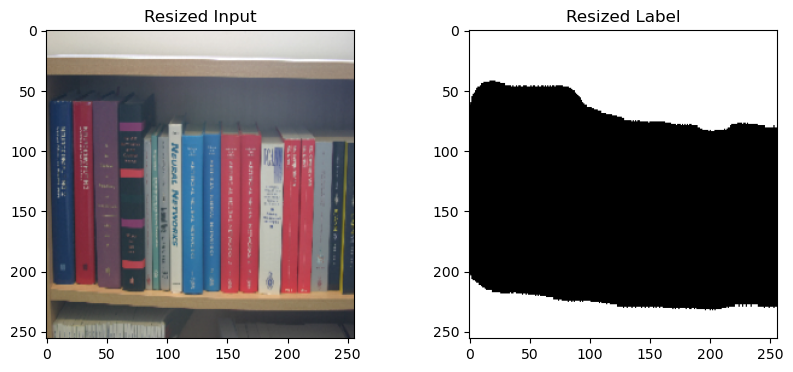

In [13]:
# 从 loader 中取出一个 batch
inputs, labels = next(iter(train_loader))

print("--- Shape Check ---")
print(f"Input Batch Shape: {inputs.shape}")   # 应为 [B, 3, 256, 256]
print(f"Label Batch Shape: {labels.shape}")   # 应为 [B, 256, 256] (注意没有 Channel 维度)

print("\n--- Label Value Check ---")
unique_labels = torch.unique(labels)
print(f"Unique values in label tensor: {unique_labels}")
# 正常情况下应该看到 tensor([0, 1, 255]) 或者其中一部分

# 可视化一下检查 Resize 是否破坏了图像
plt.figure(figsize=(10, 4))
# 显示 Batch 中的第一张图 (需要反归一化才能看清颜色)
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
vis_img = inv_normalize(inputs[0])
vis_img = vis_img.permute(1, 2, 0).numpy() # (C,H,W) -> (H,W,C)
vis_img = np.clip(vis_img, 0, 1)

plt.subplot(1, 2, 1)
plt.title("Resized Input")
plt.imshow(vis_img)

plt.subplot(1, 2, 2)
plt.title("Resized Label")
# 把 255 暂时显示为 2 以便可视化
vis_label = labels[0].numpy().copy()
vis_label[vis_label==255] = 2
plt.imshow(vis_label, cmap='gray', vmin=0, vmax=2)
plt.show()

In [17]:
from torchvision import models
import torch.nn as nn

class PretrainedDeepLab(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedDeepLab, self).__init__()
        # 1. 加载官方预训练的 DeepLabV3 (Backbone: ResNet50)
        # weights='DEFAULT' 会自动下载 ImageNet 的预训练权重
        self.model = models.segmentation.deeplabv3_resnet50(weights='DEFAULT')
        
        # 2. 修改分类头 (Classifier Head)
        # 原始模型的分类头是针对 COCO 数据集 (21类) 的，我们需要改成 num_classes (2类)
        #DeepLabV3 的分类器结构: model.classifier[4] 是最后一层 Conv2d
        old_classifier = self.model.classifier[4]
        self.model.classifier[4] = nn.Conv2d(
            in_channels=old_classifier.in_channels, 
            out_channels=num_classes, 
            kernel_size=1, 
            stride=1
        )
        
        # 3. 如果想让训练更快，可以冻结 Backbone 的前几层 (可选，这里暂时不冻结，让它微调)
        
    def forward(self, x):
        # torchvision 的分割模型输出是一个字典: {'out': tensor, 'aux': tensor}
        # 我们只需要 'out'
        return self.model(x)['out']

初始化模型

In [19]:
# 初始化模型
# n_classes = 2 (Natural, Man-made). 
# 注意：虽然还有一个 Void (255)，但我们在 Loss 计算时会忽略它，所以输出层只需要 2 个通道。
model = PretrainedDeepLab(num_classes=2).to(device)


训练

In [20]:
import torch.optim as optim

# 1. 损失函数
# ignore_index=255 是关键！它告诉模型：遇到标签为255的像素，不要计算梯度，不要学习。
criterion = nn.CrossEntropyLoss(ignore_index=255)

# 2. 优化器
# Adam 通常比 SGD 收敛更快，适合课程项目
# 学习率 lr 设为 1e-3 或 1e-4 是常见起点
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Criterion and Optimizer ready.")

Criterion and Optimizer ready.


In [21]:
from tqdm.notebook import tqdm # 专门用于 Jupyter 的进度条组件
import time

def train_one_epoch(model, loader, criterion, optimizer, device, epoch_idx, num_epochs):
    model.train()
    running_loss = 0.0
    
    # 包装 loader，desc 显示当前 Epoch 信息
    # leave=False 表示跑完这个 epoch 后进度条消失，保持界面整洁
    loop = tqdm(loader, desc=f"Epoch {epoch_idx}/{num_epochs} [Train]", leave=False)
    
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)
        
        # 1. 前向传播
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # 2. 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # 实时更新进度条末尾的 loss 显示
        loop.set_postfix(loss=loss.item())
        
    return running_loss / len(loader)

def validate(model, loader, criterion, device, epoch_idx, num_epochs):
    model.eval()
    running_loss = 0.0
    
    # 验证集通常比较快，也可以加个进度条
    loop = tqdm(loader, desc=f"Epoch {epoch_idx}/{num_epochs} [Val]", leave=False)
    
    with torch.no_grad():
        for images, masks in loop:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            
            # 验证集也显示实时 loss
            loop.set_postfix(loss=loss.item())
            
    return running_loss / len(loader)

In [22]:
num_epochs = 20
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

print(f"Starting training on {device} for {num_epochs} epochs...")
start_time = time.time()

# 外层循环也可以加一个总进度条
for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    
    # --- 训练阶段 ---
    # 注意：我们将 epoch 和 num_epochs 传进去，方便进度条显示
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, num_epochs)
    
    # --- 验证阶段 ---
    val_loss = validate(model, val_loader, criterion, device, epoch, num_epochs)
    
    # --- 记录与保存 ---
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    epoch_duration = time.time() - epoch_start
    
    # 打印本轮总结 (tqdm 进度条消失后，留下一行总结日志)
    print(f"Epoch [{epoch}/{num_epochs}] | "
          f"Time: {epoch_duration:.1f}s | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f}")
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet_model.pth")
        print("  >>> Best model saved! (New Low Val Loss)")

total_time = time.time() - start_time
print(f"\nTraining complete in {total_time/60:.1f} minutes.")

Starting training on cuda for 20 epochs...


Epoch 1/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/20] | Time: 23.4s | Train Loss: 0.4421 | Val Loss: 0.2444
  >>> Best model saved! (New Low Val Loss)


Epoch 2/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/20] | Time: 23.2s | Train Loss: 0.2546 | Val Loss: 0.2376
  >>> Best model saved! (New Low Val Loss)


Epoch 3/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/20] | Time: 23.0s | Train Loss: 0.1480 | Val Loss: 0.1790
  >>> Best model saved! (New Low Val Loss)


Epoch 4/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/20] | Time: 23.7s | Train Loss: 0.0970 | Val Loss: 0.1861


Epoch 5/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/20] | Time: 23.7s | Train Loss: 0.1069 | Val Loss: 0.2363


Epoch 6/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/20] | Time: 22.3s | Train Loss: 0.1018 | Val Loss: 0.2631


Epoch 7/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/20] | Time: 22.4s | Train Loss: 0.1133 | Val Loss: 0.1916


Epoch 8/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/20] | Time: 22.9s | Train Loss: 0.0774 | Val Loss: 0.2697


Epoch 9/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/20] | Time: 22.7s | Train Loss: 0.0717 | Val Loss: 0.3037


Epoch 10/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/20] | Time: 23.0s | Train Loss: 0.0556 | Val Loss: 0.2578


Epoch 11/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/20] | Time: 21.0s | Train Loss: 0.0442 | Val Loss: 0.2191


Epoch 12/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/20] | Time: 20.1s | Train Loss: 0.0377 | Val Loss: 0.1555
  >>> Best model saved! (New Low Val Loss)


Epoch 13/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/20] | Time: 20.3s | Train Loss: 0.0439 | Val Loss: 0.1615


Epoch 14/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/20] | Time: 20.2s | Train Loss: 0.0323 | Val Loss: 0.1661


Epoch 15/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/20] | Time: 20.1s | Train Loss: 0.0246 | Val Loss: 0.1503
  >>> Best model saved! (New Low Val Loss)


Epoch 16/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/20] | Time: 20.1s | Train Loss: 0.0244 | Val Loss: 0.1487
  >>> Best model saved! (New Low Val Loss)


Epoch 17/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/20] | Time: 20.2s | Train Loss: 0.0202 | Val Loss: 0.1945


Epoch 18/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/20] | Time: 20.1s | Train Loss: 0.0517 | Val Loss: 0.1544


Epoch 19/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/20] | Time: 20.4s | Train Loss: 0.0461 | Val Loss: 0.2568


Epoch 20/20 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/20] | Time: 20.4s | Train Loss: 0.0464 | Val Loss: 0.2400

Training complete in 7.2 minutes.


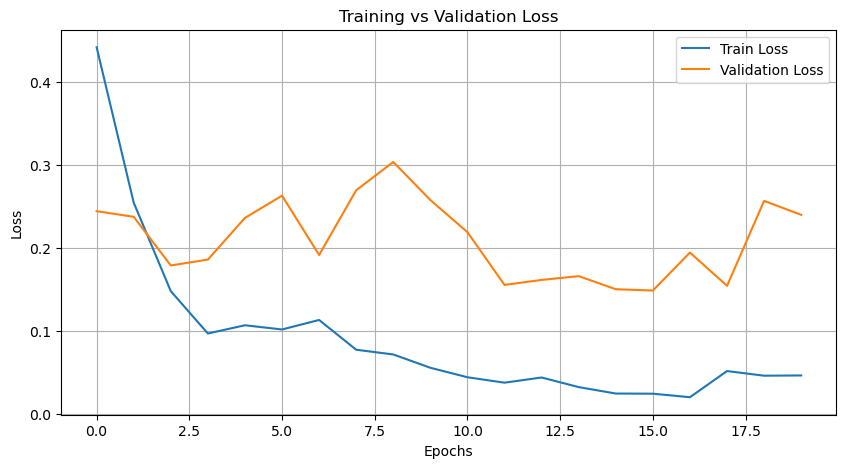

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def calculate_metrics(pred_mask, true_mask, num_classes=2, ignore_index=255):
    """
    计算一个 Batch 的 Pixel Accuracy 和 mIoU
    """
    # 1. 展平并移除 ignore_index (255) 的像素
    # 我们只关心有效的像素
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)
    
    valid_pixels = (true_mask != ignore_index)
    pred_mask = pred_mask[valid_pixels]
    true_mask = true_mask[valid_pixels]
    
    # --- Pixel Accuracy ---
    correct = (pred_mask == true_mask).sum().item()
    total = len(true_mask)
    pixel_acc = correct / (total + 1e-6) # 防止除以0
    
    # --- mIoU ---
    ious = []
    # 遍历每个类别 (0: Natural, 1: Man-made)
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        target_inds = (true_mask == cls)
        
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        
        if union == 0:
            ious.append(float('nan')) # 如果该图像中不存在该类别，忽略
        else:
            ious.append(intersection / union)
    
    # 过滤掉 nan 值求平均
    valid_ious = [x for x in ious if not np.isnan(x)]
    mean_iou = sum(valid_ious) / len(valid_ious) if valid_ious else 0.0
    
    return pixel_acc, mean_iou

In [25]:
# 1. 加载最佳模型权重
model.load_state_dict(torch.load("best_unet_model.pth"))
model.eval() # 开启评估模式

total_acc = 0.0
total_miou = 0.0
num_batches = 0

print("Starting evaluation on Test Set...")

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        masks = masks.to(device) # masks 包含 0, 1, 255
        
        # 预测
        outputs = model(images)
        # 输出是 [B, 2, H, W]，我们需要取最大概率的通道作为预测结果 -> [B, H, W]
        preds = torch.argmax(outputs, dim=1)
        
        # 计算指标
        acc, miou = calculate_metrics(preds, masks)
        
        total_acc += acc
        total_miou += miou
        num_batches += 1

print("\n" + "="*30)
print(f"Test Pixel Accuracy: {total_acc / num_batches:.4f}")
print(f"Test mIoU:           {total_miou / num_batches:.4f}")
print("="*30)

Starting evaluation on Test Set...


Testing:   0%|          | 0/32 [00:00<?, ?it/s]


Test Pixel Accuracy: 0.9592
Test mIoU:           0.8924


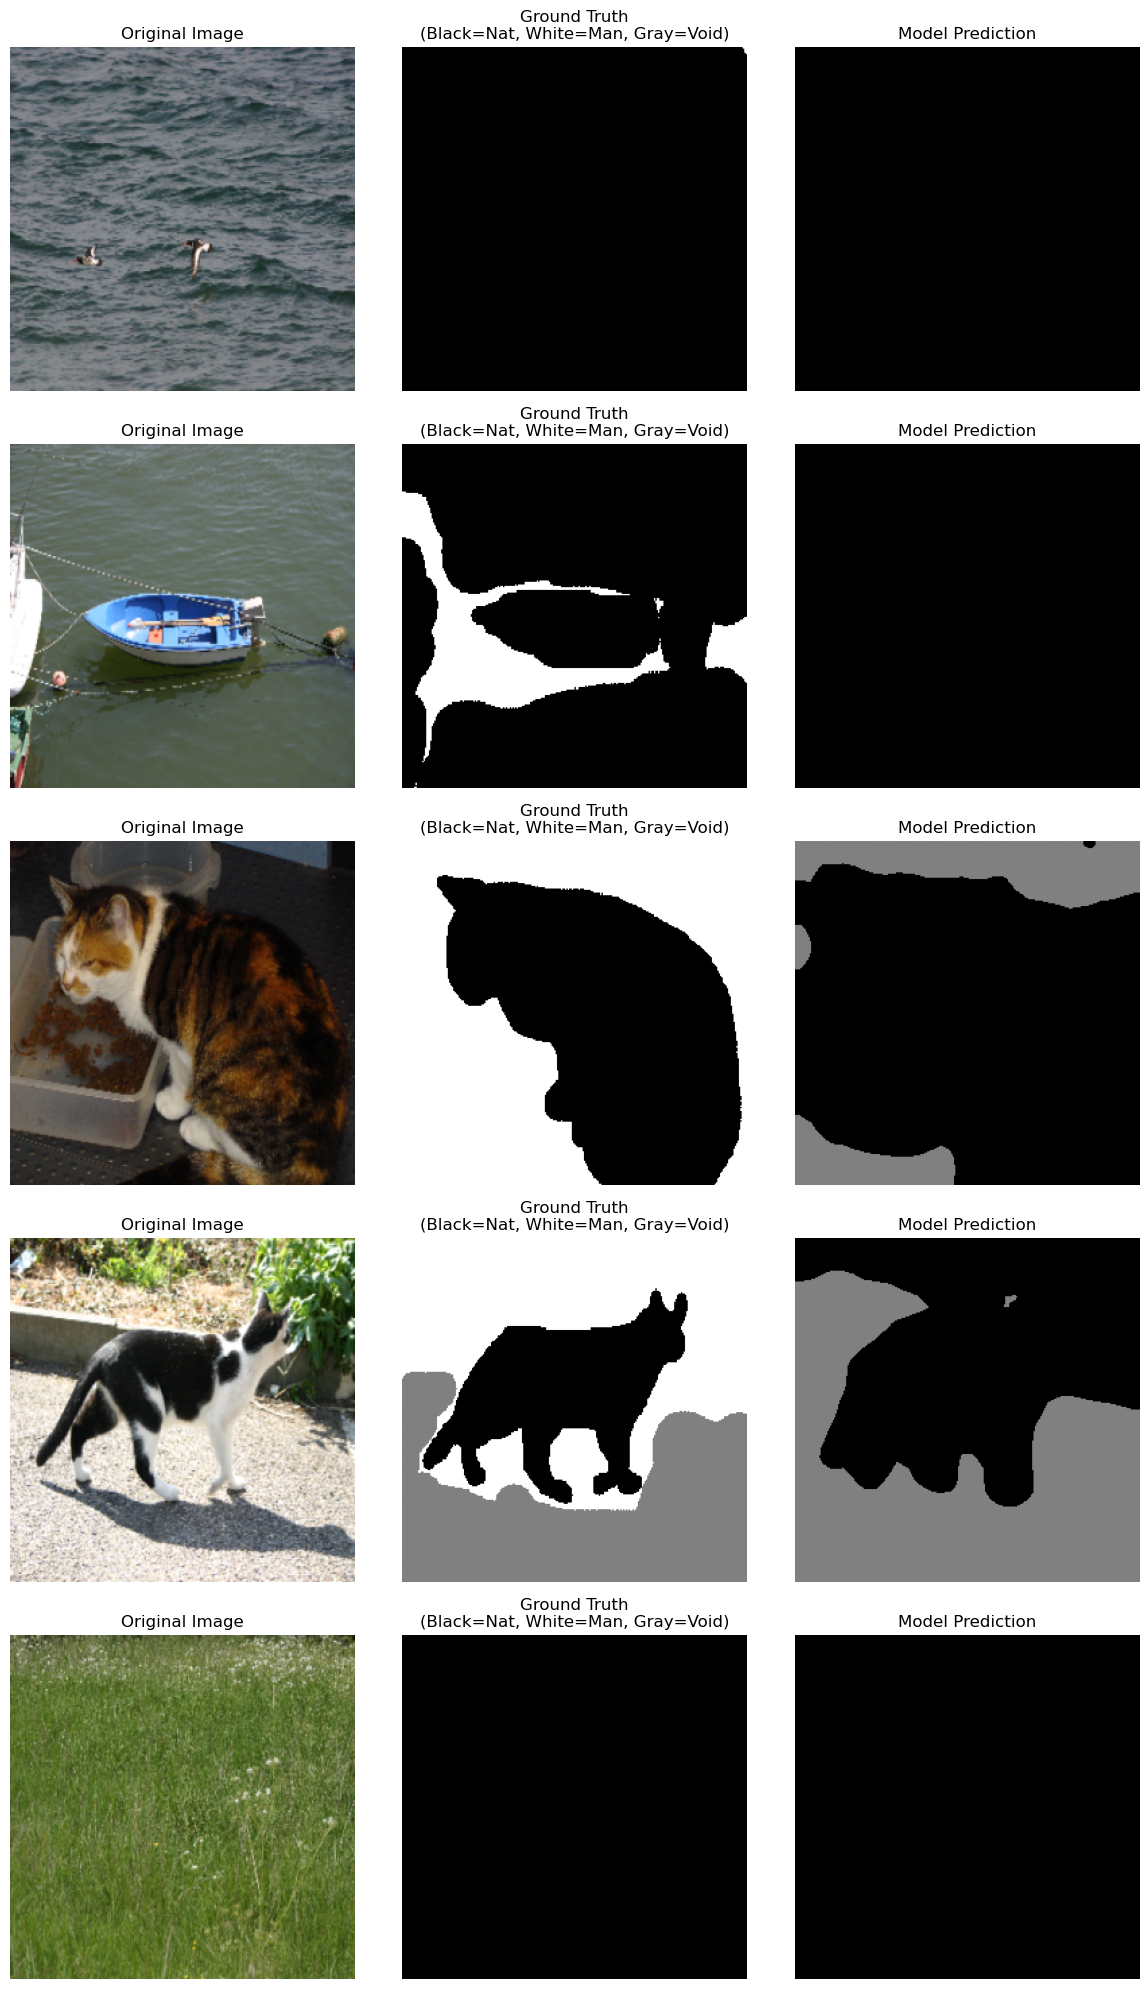

In [26]:
def visualize_predictions(model, loader, device, num_samples=3):
    model.eval()
    
    # 获取一个 batch
    images, masks = next(iter(loader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1) # [B, H, W]
    
    # 准备可视化
    plt.figure(figsize=(12, 4 * num_samples))
    
    # 反归一化工具 (为了正确显示原图颜色)
    inv_normalize = transforms.Normalize(
       mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
       std=[1/0.229, 1/0.224, 1/0.225]
    )

    for i in range(num_samples):
        if i >= len(images): break
        
        # 1. 原图
        img_tensor = inv_normalize(images[i])
        img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        
        # 2. Ground Truth
        gt_np = masks[i].cpu().numpy()
        # 把 Void(255) 变成 2 (灰色) 方便显示
        vis_gt = gt_np.copy()
        vis_gt[vis_gt == 255] = 2 
        
        # 3. Prediction
        pred_np = preds[i].cpu().numpy()
        # 预测结果里没有 255，但在显示时，我们也想把 GT 是 255 的地方“抠掉”以示公平（可选）
        # 这里我们就直接显示模型的纯预测
        
        # --- 绘图 ---
        # 原图
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_np)
        plt.title("Original Image")
        plt.axis('off')
        
        # 真实标签
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(vis_gt, cmap='gray', vmin=0, vmax=2)
        plt.title("Ground Truth\n(Black=Nat, White=Man, Gray=Void)")
        plt.axis('off')
        
        # 预测结果
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_np, cmap='gray', vmin=0, vmax=2) # 预测结果只有 0 和 1
        plt.title("Model Prediction")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# 运行可视化
visualize_predictions(model, test_loader, device, num_samples=5)